In [1]:
from inr_sos import DATA_DIR, load_mat, clear_cache, inspect_mat_fileheader, load_ic_batch, load_L_matrix

# Exploring the L-matrix (Physics wave)

In [3]:
L_mat_path = DATA_DIR / "DL-based-SoS/forward_model_lr/L.mat"
L_matrix = load_mat(L_mat_path)['L']
L_matrix.shape

Detected v7.3 MATLAB file: L.mat
  -> Reconstructing sparse matrix: /L


(131072, 4096)

Analyzing 8 Transmissions (Frames)...


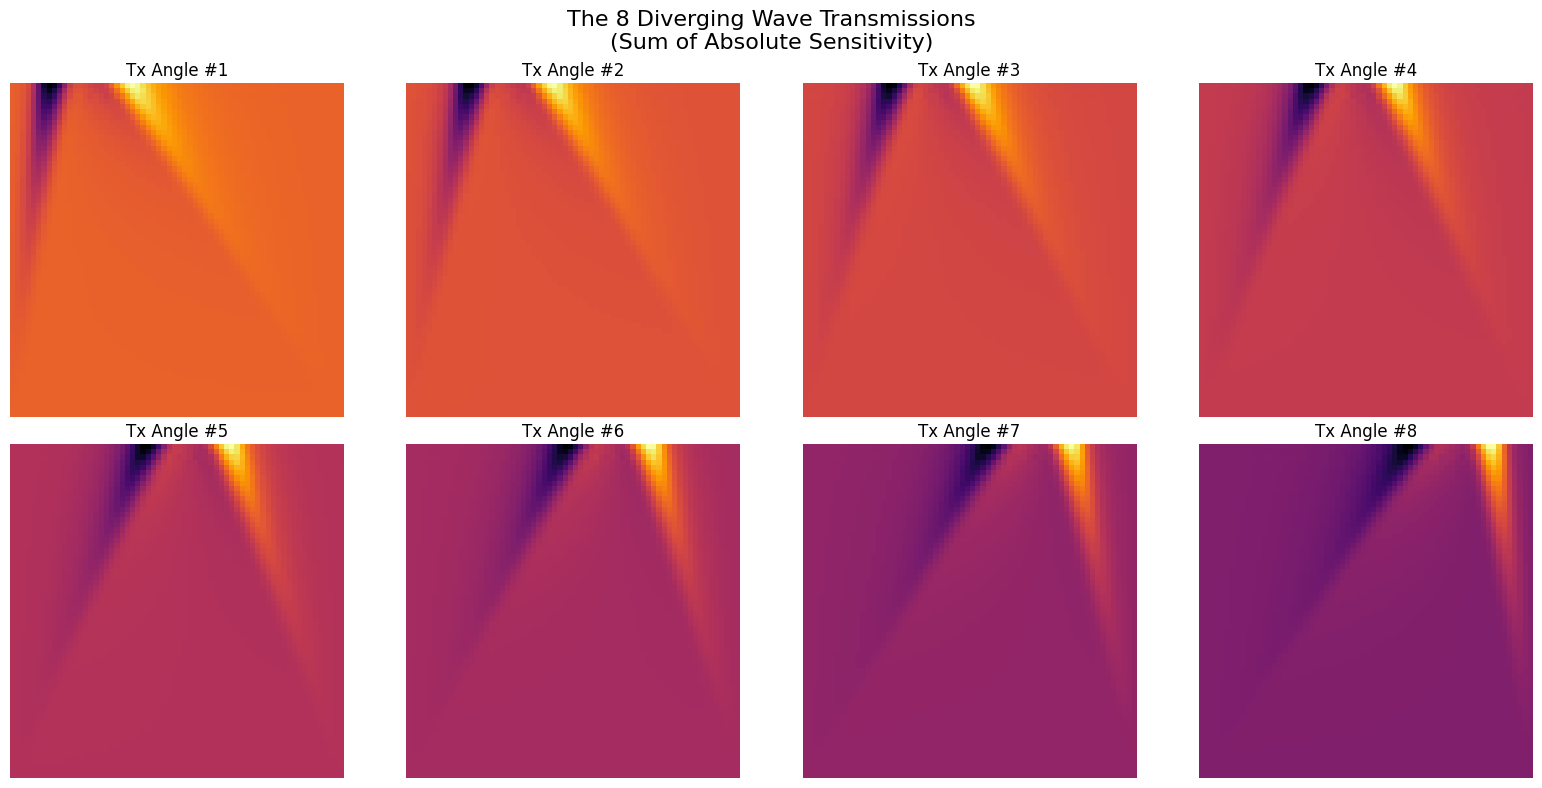

In [4]:
import matplotlib.pyplot as plt
import numpy as np
n_pixels_recon = 64 * 64   # 4096
n_pixels_data = 128 * 128  # 16384 (Size of one "Frame")
n_angles = 8

print(f"Analyzing {n_angles} Transmissions (Frames)...")

# 3. VISUALIZE THE 8 ANGLES
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(n_angles):
    # Calculate start and end row for this angle
    start_row = i * n_pixels_data
    end_row = (i + 1) * n_pixels_data
    
    # Extract the block of 16,384 rows for this angle
    # This represents ALL rays fired during Transmission #i
    L_chunk = L_matrix[start_row:end_row, :]
    
    # "Collapse" the rays to see the overall coverage
    # We sum along the rows (axis 0) to see which pixels were hit the most
    coverage_map_flat = L_chunk.sum(axis=0) # Result shape: (1, 4096)
    
    # Reshape to Image (Remember: Order F)
    coverage_img = np.array(coverage_map_flat).reshape((64, 64), order='F')
    
    # Plot
    im = axes[i].imshow(coverage_img, cmap='inferno')
    axes[i].set_title(f"Tx Angle #{i+1}")
    axes[i].axis('off')

plt.suptitle("The 8 Diverging Wave Transmissions\n(Sum of Absolute Sensitivity)", fontsize=16)
plt.tight_layout()
plt.show()

# Exploring the grid parameter, and mask data

## grid parameter

In [5]:
grid_parameters_matrix = load_mat(DATA_DIR / "DL-based-SoS/forward_model_lr/grid_parameters.mat")

In [6]:
grid_parameters_matrix.keys()

dict_keys(['__header__', '__version__', '__globals__', 'xDT', 'xax_sos', 'xdt', 'zDT', 'zax_sos', 'zdt'])

In [7]:
print(
grid_parameters_matrix["xDT"].shape,
grid_parameters_matrix["xax_sos"].shape,
grid_parameters_matrix["xdt"].shape,
grid_parameters_matrix["zDT"].shape,
grid_parameters_matrix["zax_sos"].shape,
grid_parameters_matrix["zdt"].shape, sep="\n")

(1, 128)
(1, 64)
(128, 128)
(1, 128)
(1, 64)
(128, 128)


In [8]:
grid_parameters_matrix['xax_sos']

array([[-0.0189, -0.0183, -0.0177, -0.0171, -0.0165, -0.0159, -0.0153,
        -0.0147, -0.0141, -0.0135, -0.0129, -0.0123, -0.0117, -0.0111,
        -0.0105, -0.0099, -0.0093, -0.0087, -0.0081, -0.0075, -0.0069,
        -0.0063, -0.0057, -0.0051, -0.0045, -0.0039, -0.0033, -0.0027,
        -0.0021, -0.0015, -0.0009, -0.0003,  0.0003,  0.0009,  0.0015,
         0.0021,  0.0027,  0.0033,  0.0039,  0.0045,  0.0051,  0.0057,
         0.0063,  0.0069,  0.0075,  0.0081,  0.0087,  0.0093,  0.0099,
         0.0105,  0.0111,  0.0117,  0.0123,  0.0129,  0.0135,  0.0141,
         0.0147,  0.0153,  0.0159,  0.0165,  0.0171,  0.0177,  0.0183,
         0.0189]])

## mask data

In [9]:
mask_vector = load_mat(DATA_DIR / "DL-based-SoS/forward_model_lr/mask.mat")['mask']

Detected v7.3 MATLAB file: mask.mat


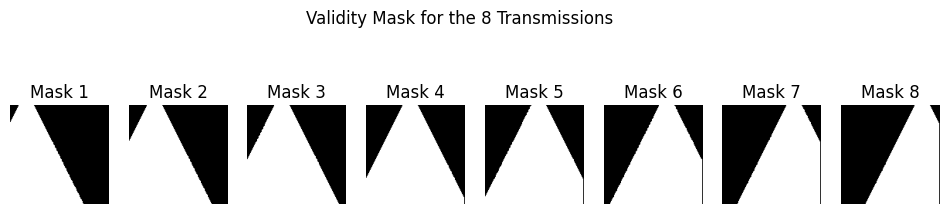

In [10]:
# Assume mask is loaded as 'mask_vector' shape (131072, 1)
# Reshape into (128, 128, 8)
# We use order='F' because it comes from MATLAB
mask_matrix = mask_vector.reshape((128, 128, 8), order='F')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(mask_matrix[:, :, i], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')
plt.suptitle("Validity Mask for the 8 Transmissions")
plt.show()

# exploring K-wave data

In [2]:
test = inspect_mat_fileheader(DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat")


[HDF5 Format Detected]
  Key: 'A' | Shape: (4096, 131072) | Type: Dataset
  Key: 'imgs_gt' | Shape: (10000, 64, 64) | Type: Dataset
  Key: 'measmnts' | Shape: (10000, 131072) | Type: Dataset
  Key: 'nanidx' | Shape: (10000, 131072) | Type: Dataset


Loading L Matrix...
L Matrix Shape: (131072, 4096)
Loading Sample #0...
Mismatch Error (MAE): 7.306892e-09


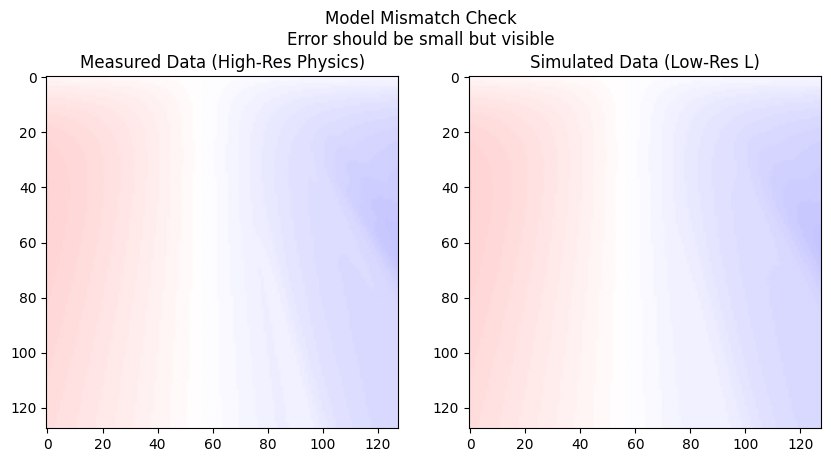

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 1. LOAD MATRIX (Just once)
print("Loading L Matrix...")
L_matrix = load_L_matrix(DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat")
print(f"L Matrix Shape: {L_matrix.shape}") # Should be (131072, 4096)

# 2. LOAD SAMPLE #0
print("Loading Sample #0...")
s_gt, d_meas, mask = load_ic_batch(DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat", idx=100)

# 3. SIMULATE (Model Mismatch Check)
# d_pred = L * s
d_pred = L_matrix.dot(s_gt)

# 4. ERROR ANALYSIS
# Only check valid regions
valid_idx = (mask == 1)
diff = (d_pred - d_meas) * mask
mae = np.mean(np.abs(diff[valid_idx]))

print(f"Mismatch Error (MAE): {mae:.6e}")
# Expectation: Small error (approx 1e-4 or 1e-5), but NOT zero.

# 5. VISUALIZE
# Reshape for plotting (Angle #4)
frame_len = 128*128
start = 3 * frame_len
end = 4 * frame_len

img_pred = d_pred[start:end].reshape((128, 128), order='F')
img_meas = d_meas[start:end].reshape((128, 128), order='F')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_meas, cmap='seismic', vmin=-1e-5, vmax=1e-5)
plt.title("Measured Data (High-Res Physics)")

plt.subplot(1, 2, 2)
plt.imshow(img_pred, cmap='seismic', vmin=-1e-5, vmax=1e-5)
plt.title("Simulated Data (Low-Res L)")

plt.suptitle(f"Model Mismatch Check\nError should be small but visible")
plt.show()

# Training Inverse Crime data

## Confirming the data 

In [22]:
from inr_sos.utils.dataset import USDataset
import torch

inverse_data_file = DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat"
param_grid_file =  DATA_DIR /  "DL-based-SoS/forward_model_lr/grid_parameters.mat"
print(inverse_data_file)
print(param_grid_file)

# 1. Init Dataset
print("Initializing Dataset...")
 = USDataset(inverse_data_file, param_grid_file)
print(f"Dataset Length: {len(dataset)}")

# 2. Get One Sample
sample = dataset[0]
coords = sample['coords']
s_gt = sample['s_gt']
d_meas = sample['d_meas']
mask = sample['mask']

print(f"\n--- Shape Verification ---")
print(f"Inputs (x,z):  {coords.shape}  (Expected: 4096, 2)")
print(f"Target (s):    {s_gt.shape}    (Expected: 4096, 1)")
print(f"Data (d):      {d_meas.shape}  (Expected: 131072, 1)")
print(f"Mask:          {mask.shape}    (Expected: 131072, 1)")

# 3. Verify Physics Compatibility (L * s = d)
# Move to PyTorch for a quick check
L = dataset.get_L_matrix()
print(f"L Matrix:      {L.shape}  (Expected: 131072, 4096)")

print("\n--- Tensor Math Check ---")
# d_pred = L @ s
d_pred = torch.matmul(L, s_gt)
print(f"Prediction shape: {d_pred.shape}")

# Calculate Error (Should be ~1e-9 like before)
diff = (d_pred - d_meas) * mask
mae = torch.mean(torch.abs(diff))
print(f"PyTorch MAE Check: {mae.item():.6e}")

/home/habenhadush/github/mia/y2/s4/INR-SoS-Recon/data/DL-based-SoS/train-VS-8pairs-IC-081225.mat
/home/habenhadush/github/mia/y2/s4/INR-SoS-Recon/data/DL-based-SoS/forward_model_lr/grid_parameters.mat
Initializing Dataset...
Loading and Transposing L-Matrix (A)...
Dataset Length: 10000

--- Shape Verification ---
Inputs (x,z):  torch.Size([4096, 2])  (Expected: 4096, 2)
Target (s):    torch.Size([4096, 1])    (Expected: 4096, 1)
Data (d):      torch.Size([131072, 1])  (Expected: 131072, 1)
Mask:          torch.Size([131072, 1])    (Expected: 131072, 1)
L Matrix:      torch.Size([131072, 4096])  (Expected: 131072, 4096)

--- Tensor Math Check ---
Prediction shape: torch.Size([131072, 1])
PyTorch MAE Check: 4.357129e-10


## trainging on the inverse crime data
testing with SIREN from the paper:(Sitzmann et al., 2020)

In [27]:
def tv_regularization(img_tensor):
    """
    Computes Total Variation (TV) loss to encourage smoothness.
    img_tensor shape: (Batch, 4096, 1) -> We reshape to (64, 64) first
    """
    # Reshape to image (Batch, Height, Width)
    img = img_tensor.view(-1, 64, 64)
    
    # Calculate difference between adjacent pixels
    diff_h = torch.abs(img[:, :, 1:] - img[:, :, :-1]) # Horizontal diff
    diff_v = torch.abs(img[:, 1:, :] - img[:, :-1, :]) # Vertical diff
    
    return torch.mean(diff_h) + torch.mean(diff_v)

--- Training on Device: cuda ---
Starting Training Loop...
Step 0: Data Loss (MSE) = 1.853982e-07 | Image Error (MSE) = 7.416013e-04
Step 100: Data Loss (MSE) = 5.502337e-09 | Image Error (MSE) = 1.080487e-06
Step 200: Data Loss (MSE) = 3.805069e-09 | Image Error (MSE) = 5.801019e-07
Step 300: Data Loss (MSE) = 2.986298e-09 | Image Error (MSE) = 3.893092e-07
Step 400: Data Loss (MSE) = 3.060463e-09 | Image Error (MSE) = 4.755540e-07
Step 500: Data Loss (MSE) = 2.162157e-09 | Image Error (MSE) = 2.595514e-07
Step 600: Data Loss (MSE) = 1.456020e-09 | Image Error (MSE) = 1.148409e-07
Step 700: Data Loss (MSE) = 1.402569e-09 | Image Error (MSE) = 1.074039e-07
Step 800: Data Loss (MSE) = 1.080267e-09 | Image Error (MSE) = 5.218515e-08
Step 900: Data Loss (MSE) = 9.642357e-10 | Image Error (MSE) = 4.104831e-08

Training Complete. Plotting result...


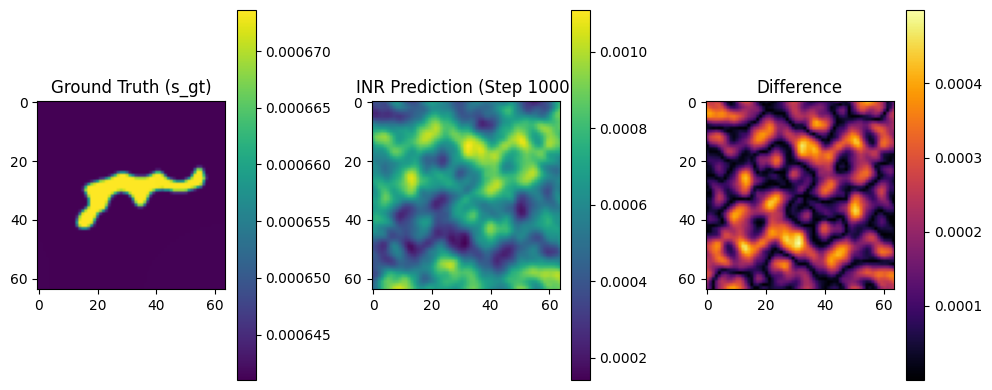

In [38]:
from inr_sos.utils.dataset import USDataset
from inr_sos.MLP.models import INR_Network
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
GPU_ID = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 1e-4
STEPS = 1000
PATIENT_ID = 10  # We train on Sample #0 first

def train():
    print(f"--- Training on Device: {DEVICE} ---")
    # 1. LOAD DATA
    sample = dataset[PATIENT_ID] # Load one specific patient
    
    # Move everything to GPU
    # Coordinates (Inputs): (4096, 2)
    coords = sample['coords'].to(DEVICE)
    # Target Data (Measurements): (131072, 1)
    d_true = sample['d_meas'].to(DEVICE)
    # Ground Truth Image (For checking, not training): (4096, 1)
    s_gt = sample['s_gt'].to(DEVICE)
    # Mask: (131072, 1)
    mask = sample['mask'].to(DEVICE)
    
    # Load Physics Matrix L
    L_matrix = dataset.get_L_matrix().to(DEVICE) # (131072, 4096)
    
    # 2. INIT MODEL
    model = INR_Network().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    print("Starting Training Loop...")
    loss_history = []
    
    s_background = 1.0 / 1540.0
    LAMBDA_TV = 1e-5
    
    for step in range(STEPS):
        optimizer.zero_grad()
        
        # A. FORWARD PASS (The INR)
        # Ask: "What is the slowness at these coords?"
        raw_output = model(coords)
        s_pred = raw_output # Output: (4096, 1)
        
        # B. PHYSICS PASS (The Forward Model)
        # Ask: "If that is the slowness, what is the displacement?"
        d_pred = torch.matmul(L_matrix, s_pred) # (131072, 1)
        diff = (d_pred - d_true) * mask
        loss_data = torch.mean(diff ** 2)
        loss_tv = tv_regularization(s_pred)
        # C. COMPUTE LOSS (Masked MSE)
        # Only penalize errors inside the valid beam
        #diff = (d_pred - d_true) * mask
        loss = loss_data + (LAMBDA_TV * loss_tv)
        #loss = torch.mean(diff ** 2)
        
        # D. BACKPROP
        loss.backward()
        optimizer.step()
        
        # Logging
        if step % 100 == 0:
            # Also check error against Ground Truth Image (s_gt)
            # (Note: In real life we don't have s_gt, but here we peek at it)
            img_loss = torch.mean((s_pred - s_gt)**2).item()
            print(f"Step {step}: Data Loss (MSE) = {loss.item():.6e} | Image Error (MSE) = {img_loss:.6e}")
            loss_history.append(loss.item())

    # 3. VISUALIZATION
    print("\nTraining Complete. Plotting result...")
    
    # Detach from GPU for plotting
    s_pred_np = s_pred.detach().cpu().numpy().reshape(64, 64)
    s_gt_np = s_gt.detach().cpu().numpy().reshape(64, 64)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth (s_gt)")
    plt.imshow(s_gt_np, cmap='viridis')
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.title(f"INR Prediction (Step {STEPS})")
    plt.imshow(s_pred_np, cmap='viridis')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.title("Difference")
    plt.imshow(np.abs(s_gt_np - s_pred_np), cmap='inferno')
    plt.colorbar()
    
    plt.tight_layout()
    #plt.savefig('result_patient_0.png')
    plt.show()

if __name__ == "__main__":
    train()